In [1]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from datetime import datetime



In [2]:

#   --------------------------- parameters and data --------------
PATH = '../resources/inventory/'
supplier_list = [200051]  #200067 -julia, 200051 - donson
# Needs to open files and save them again as xlsx inside the excel

# important needs to delete first column of date which is empty
df = pd.read_excel(PATH + 'customer_transactions.xlsx', parse_dates=['Date'])  # inventory/transactions/reports/detailed/customer shipments
df.columns.values[0] = 'empty'
df.columns.values[3] = 'Date'

purchase_data_df = pd.read_excel(PATH + 'purchase_parameters.xlsx')#  invetory/part catalog/part parameter/purchae MRP parameters for parts
purchase_data_df = purchase_data_df[purchase_data_df['Preferred Vendor'].isin(supplier_list)]
availability_df = pd.read_excel(PATH + 'availability.xlsx')  # inventory/part catalog/parts report/ parts availability detailed
#start_date = '07/12/21'  # all information retrieved from the ERP# software will be discarded. format 'dd\mm\yy'
#start_date = start_date.split('/')[0] + '/' + start_date.split('/')[1] + '/' + start_date.split('/')[2]  # changing order


In [7]:
%matplotlib qt

pn_list = list(purchase_data_df['Part Number'].unique())
order_part_list = []
forcast_steps = 12
avail_list = []
security_stock_list = []
recommended_order_list = []
sampling_period = 'M'
how_many_weeks = 4
start_date = '2016-07-01'
forecast_list = []
train_test_ratio = 1
#pn_list = ['A12-1016', 'A12-1270']
part_index = 0
fig, ax = plt.subplots()

part_index = 0
def on_key(event):
    global part_index
    if event.key == 'up':
        part_index += 1

    elif event.key == 'down':
        part_index -= 1
    part_index = part_index % len(pn_list)
    ax.title.set_text(pn_list[part_index])

    part = pn_list[part_index]
    history_df = df[df['Part Number'] == part ][['Date', 'Quantity']]
    history_df = history_df[history_df['Date'] > start_date]

    history_df = history_df.set_index('Date')
    history_df = history_df.resample(sampling_period).sum()

    data = history_df['Quantity']
    # Split data into training and test sets
    train, test = data[:int(len(data)*train_test_ratio)], data[int(len(data)*train_test_ratio):]

    # Fit the model
    try:
        model = ExponentialSmoothing(train, trend='add', seasonal=None,seasonal_periods=1)
        model_fit = model.fit()
        order_part_list.append(part)
        forecast_list.append(model_fit.forecast(forcast_steps).sum())
        avail_list.append(availability_df[availability_df['Part Number'] == part]['Quantity'].values[0])

        recommended_order_list.append(forecast_list[-1]-avail_list[-1])
        # Forecast
        pred = model_fit.predict(start=train.index[-1], end=train.index[-1] + pd.Timedelta(weeks=forcast_steps*how_many_weeks))
        train = train.resample('2W').sum()
        test = test.resample('2W').sum()
        pred = pred.resample('2W').sum()

        # Plot the results
        plt.cla()
        ax.plot(train.index, train, label='Train', color='yellow')
        ax.plot(test.index, test, label='Test', color='blue')
        ax.plot(pred.index, pred, label='Holt-Winters', color='red')
        ax.legend(loc='best')
        ax.xticks(rotation=45)
        ax.title(part)
    except Exception as e:
            print('error with   part: ', part)
            print(e)
    fig.canvas.draw()



def on_click(event):
    global flag
    flag = False

fig.canvas.mpl_connect('key_press_event', on_key)
plt.show()


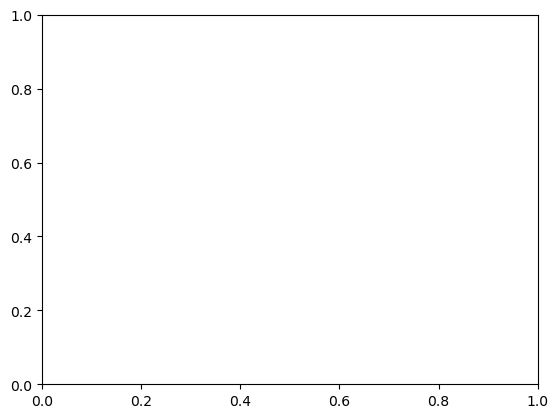

In [8]:

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

order_df = pd.DataFrame({'Part Number': order_part_list, 'Forecast': forecast_list, 'Availability': avail_list, 'Recommended Order': recommended_order_list})
order_df.to_excel(PATH + 'order%s.xlsx'%current_time, index=False)
order_parameter ={'start_date' : start_date, 'sampling_period' : sampling_period, 'forcast_steps' : forcast_steps, 'train_test_ratio' : train_test_ratio, 'supplier_list' : supplier_list}
pd.DataFrame(order_parameter, index=[1]).to_excel(PATH + 'order_parameter%s.xlsx'%current_time, index=False)

In [22]:
plt.show()


In [4]:
import pandas as pd

# Load your data
# We'll use a sample dataset for demonstration

data = history_df['Quantity']
# Split data into training and test sets
train, test = data[:int(len(data)*0.7)], data[int(len(data)*0.7):]

# Fit the model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast
pred = model_fit.predict(start=test.index[0], end=test.index[-1])
train = train.resample('Q').sum()
test = test.resample('Q').sum()
pred = pred.resample('Q').sum()

# Plot the results
plt.plot(train.index, train, label='Train', color='yellow')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(pred.index, pred, label='Holt-Winters', color='red')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.show()


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.